In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchsummary
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)  
print(dev)

cpu


## Load and visualize data

In [5]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df["label"], random_state=123)

In [8]:
BATCH_SIZE = 32

## Create dataset

In [9]:
class MNISTDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, transform=None, target_transform=None):
        self.labels = np.zeros((len(dataframe)))
        if "label" in dataframe:
            self.labels = dataframe.label.values
            dataframe = dataframe.drop(labels=["label"], axis=1)
        self.images = dataframe.values.reshape((len(self.labels), 28, 28)).astype(np.uint8)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = np.expand_dims(self.images[idx], axis=-1)
        image = np.repeat(image, 3, axis=-1)
        image = transforms.ToTensor()(image)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [10]:
augmentation = transforms.Compose(
    [
        transforms.RandomRotation(20),
    ]
)

train_ds = MNISTDataset(train_df, transform=augmentation)
val_ds = MNISTDataset(val_df)
test_ds = MNISTDataset(test_df)

train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

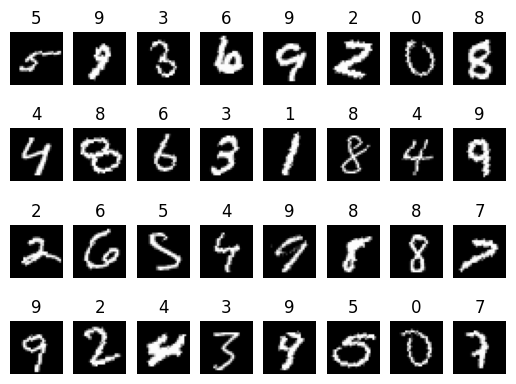

In [11]:
train_sample_image_batch, train_sample_label_batch = next(iter(train_dataloader))

for i, image in enumerate(train_sample_image_batch):
    plt.subplot(BATCH_SIZE // 8, 8, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(train_sample_label_batch[i].numpy())
    plt.axis("off")

## Create model

In [1]:
class SimpleCNN(nn.Module):
    """Some Information about SimpleCNN"""
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_block_1_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv_block_1_2 = nn.Conv2d(self.conv_block_1_1.out_channels, 64, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv_block_2_1 = nn.Conv2d(self.conv_block_1_2.out_channels, 128, 3, padding=1)
        self.conv_block_2_2 = nn.Conv2d(self.conv_block_2_1.out_channels, 128, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv_block_3_1 = nn.Conv2d(self.conv_block_2_2.out_channels, 256, 3, padding=1)
        self.conv_block_3_2 = nn.Conv2d(self.conv_block_3_1.out_channels, 256, 3)
        self.fc_1 = nn.Linear(self.conv_block_3_2.out_channels * 3**2, 10)

    def forward(self, x):
        x = F.relu(self.conv_block_1_1(x))
        x = F.relu(self.conv_block_1_2(x))
        x = self.pool1(x)
        x = F.relu(self.conv_block_2_1(x))
        x = F.relu(self.conv_block_2_2(x))
        x = self.pool2(x)
        x = F.relu(self.conv_block_3_1(x))
        x = F.relu(self.conv_block_3_2(x))
        x = torch.flatten(x, 1)
        x = self.fc_1(x)
        x = F.softmax(x, dim=1)
        
        return x

model = SimpleCNN()
torchsummary.summary(model, (3, 28, 28))

NameError: name 'nn' is not defined

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [15]:
EPOCHS = 20

for epoch in range(EPOCHS):
    train_loss = 0.0
    accuracy = 0.0
    
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        accuracy += torch.sum(torch.argmax(outputs, dim=1) == labels) / len(outputs)
        train_loss += loss.item()

    print(f'[{epoch + 1}] loss: {train_loss / len(train_dataloader):.3f}, accuracy: {accuracy / len(train_dataloader):.3f} - ', end="")

    val_loss = 0.0
    val_accuracy = 0.0
    for i, data in enumerate(val_dataloader, 0):
        inputs, labels = data

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_accuracy += torch.sum(torch.argmax(outputs, dim=1) == labels) / len(outputs)
        val_loss += loss.item()

    print(f'val_loss: {val_loss / len(val_dataloader):.3f}, val_accuracy: {val_accuracy / len(val_dataloader):.3f}')

print('Finished Training')

[1] loss: 2.303, accuracy: 0.106 - val_loss: 2.303, val_accuracy: 0.173


KeyboardInterrupt: 

[2 0 8 0 3 7 0 3 0 3 5 7 4 0 4 3]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


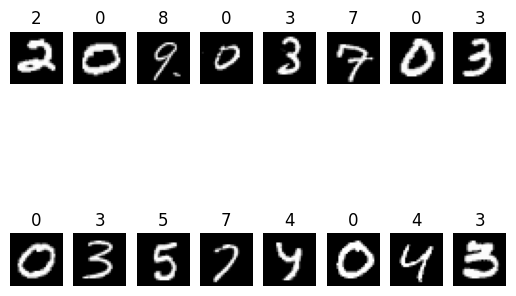

In [11]:
train_sample_image_batch, train_sample_label_batch = next(iter(test_dataloader))

outputs = model(train_sample_image_batch)
predictions = np.argmax(outputs.detach().numpy(), axis=1)
print(predictions)
print(train_sample_label_batch.detach().numpy())

for i, image in enumerate(train_sample_image_batch):
    plt.subplot(2, 8, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(predictions[i])
    plt.axis("off")


In [39]:
predictions = np.array([])

for i, data in enumerate(test_dataloader, 0):
    inputs, labels = data

    outputs = model(inputs)
    predictions = np.append(predictions, torch.argmax(outputs, dim=1).numpy())

predictions

array([2., 0., 8., ..., 3., 7., 2.])

In [40]:
submission_df = pd.read_csv("./sample_submission.csv")
submission_df.Label = predictions.astype(np.uint8)
submission_df.to_csv("./submission.csv", index=False)
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,8
3,4,0
4,5,3


In [13]:
torch.save(model.state_dict(), "./saved_models/model.pt")